# Домашнее задание №7: деревья, случайный лес (14.5 баллов)

## Часть 1: основы построения решающие дерева

начнём с простого...

### Задание 1.1 (1 балл)
Пусть известно, что в вершину решающего дерева попали 10 объектов, 8 из которых имеют метку класса $k_1$, а 2 - $k_2$. Посчитайте энтропию (с натуральным логарифмом). Ответ округлите до двух знаков после запятой.

In [322]:
from math import log 

print(round((-8/10 * log(8/10, np.e) - 2/10 * log(2/10, np.e)), 2))

0.5


### Задание 1.2 (1 балл)
Пусть дополнительно известно, что вершина из предыдущего задания не является листовой и возможно такое разбиение, что в левое поддерево попадут все объекты класса $k_1$, а в правое - класса $k_2$. Посчитайте критерий информативности (в формулировке разности impurity пришедшей выборки и полученного разбиения) такой вершины с применением индекса Джини. Ответ округлите до двух знаков после запятой.

Нужно посчитать \\(H(R) - H(R_r) - H(R_l)\\) (можно считать по той сложной формуле, но по заданию кажется, что нужно обычную разность, которая может быть не очень информативной).

\\(H(p_1, ..., p_k) = \sum p_i(1 - p_i)\\)

In [15]:
H_R = 8/10 * (1 - 8/10) + 2/10 * (1 - 2/10)
H_R_r = 0
H_R_l = 0
print(round(H_R - H_R_r - H_R_l, 2))

0.32


### Задание 1.3 (0.5 балла)
Пусть при построении дерева образовалась листовая вершина с 10 объектами, значения целевой переменной для которых следующие: [1, 10, 5, 18, 100, 30, 50, 61, 84, 47] (решается задача регрессии). Чему будут равны предсказания модели для этих объектов?

In [17]:
print(sum([1, 10, 5, 18, 100, 30, 50, 61, 84, 47])/10)  # по умолчанию хотим оптимизировать MSE

40.6


## Часть 2: решающие деревья

### Задание 2.1 (2 балла)
Первым делом реализуйте функцию `find_best_split`, которая должна находить оптимальное разбиение подмножества обучающей выборки. При решении задачи регрессии испольуйте дисперсию подвыборки, при решении задачи классификации используйте критерий Джини. Эту функцию можно протестировать на датасете `Boston` из `sklearn`.

In [74]:
from collections import Counter
from typing import Dict, List, Tuple, Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import load_boston

In [75]:
boston = load_boston()
X = pd.DataFrame(data=boston["data"], columns=boston["feature_names"])
y = boston["target"]

# X.head()
# print(boston["DESCR"])

При решении задания имейте в виду, что под критерием Джини подразумевается такая функция:

$$Q(R) = -\frac {|R_{\ell}|}{|R|}H(R_\ell) -\frac {|R_r|}{|R|}H(R_r) ,$$

где $R$ — множество объектов, попавших в вершину, $R_{\ell}$ и $R_r$ — объекты, попавшие в левое и правое поддеревья,
$H(R) = 1 - p_1^2 - p_0^2$, $p_1$, $p_0$ — доли объектов класса 1 и 0 соответственно.

Для категориальных признаков применяется наивный алгоритм разбиения: мы пытаемся найти одно значение, разбиение по которому сильнее всего увеличит критерий информативности. Иными словами, объекты с конкретным значением признака отправляем в левое поддерево, остальные - в правое. Обратите внимание, что это далеко не оптимальные способ учёта категориальных признаков. Например, можно было бы на каждое значение категориального признака создавать отдельное поддерево или использовать более сложные подходы. Подробнее об этом можно прочитать в конспектах [лекций](https://github.com/esokolov/ml-course-hse/blob/master/2019-fall/lecture-notes/lecture07-trees.pdf) по машинному обучению на ПМИ (раздел «Учёт категориальных признаков»).

В качестве подсказок реализации можете пользоваться кодом из бонусной части семинара по решающим деревьям (скачайте решённую версию ноутбука).

**Note:** Разрешается делать цикл для перебора порогов, но возможна имплементация без него. За имплементацию без цикла бонус 0.7 балла

**Пожалуйста, подскажите**: когда я не делала инициализацию для threshold_best нулями сразу и искала gini_best как максимум из ginis, у меня вылазила в 2.5 ошибка, что ginis пуст и максимум взять нельзя. Потом поправила на такое, и ошибка перестала вылезать. Но я очень хочу понять, что было не так. Попыталась в 2.5 исправить код так, чтобы никуда точно не попадало пустое feature_vector. Но все равно была такая ошибка. Почему она? Как возникает? 😭

In [76]:
def find_best_split(
    feature_vector: Union[np.ndarray, pd.DataFrame], 
    target_vector: Union[np.ndarray, pd.Series],
    task: str = "classification",
    feature_type: str = "real"
) -> Tuple[np.ndarray, np.ndarray, float, float]:
    """
    Указания:
    * Пороги, приводящие к попаданию в одно из поддеревьев пустого множества объектов, не рассматриваются.
    * В качестве порогов, нужно брать среднее двух сосдених (при сортировке) значений признака
    * Поведение функции в случае константного признака может быть любым.
    * При одинаковых приростах Джини или дисперсии нужно выбирать минимальный сплит.
    * За наличие в функции циклов балл будет снижен. Векторизуйте! :)

    :param feature_vector: вещественнозначный вектор значений признака
    :param target_vector: вектор классов объектов,  len(feature_vector) == len(target_vector)
    :param task: либо `classification`, либо `regression`
    :param feature_type: либо `real`, либо `categorical`
    
    :return thresholds: отсортированный по возрастанию вектор со всеми возможными порогами, по которым объекты можно
     разделить на две различные подвыборки, или поддерева
    :return ginis: вектор со значениями критерия Джини для каждого из порогов в thresholds len(ginis) == len(thresholds)
    :return threshold_best: оптимальный порог (число)
    :return gini_best: оптимальное значение критерия Джини (число)
    """
    
    # в качестве порогов нужно брать среднее двух соседних при сортировке значений признака. Отсортируем:
    
    thresholds = np.sort(np.unique(feature_vector))
    
    # обработаем вещественный случай. Надо брать среднее соседних. Сделаю для этого два новых вектора: в одном все 
    # признаки, кроме последнего, а в другом --- все, кроме первого. Сложу их поэлементно и поделю на 2. Например, 
    # если было 1-2-3-4, то будут два вектора: 2-3-4, 1-2-3. Сложу и поделю на 2: (1 + 2)/2-(2 + 3)/2-(3 + 4)/2

    if feature_type == 'real':
        t_first = thresholds[:-1]
        t_last = thresholds[1:]
        thresholds = (t_first + t_last)/2
        threshold_best = 0
    
    else:
        threshold_best = '0'
    
    # мощность множества объектов:
    R = len(target_vector)
    
    # массив с значениями критерия Джини
    ginis = np.array([])
    gini_best = -np.inf
    
    i = -1
    while i + 1 < len(thresholds):
        i += 1
        
        # теперь t --- конкретное значение порога
        t = thresholds[i]
        
        # разбиение
        if feature_type == 'categorical':
            target_vector_L = target_vector[feature_vector == t]
            target_vector_R = target_vector[feature_vector != t]
        else:
            target_vector_L = target_vector[feature_vector <= t]
            target_vector_R = target_vector[feature_vector > t]
        
        # размер левого разбиения:
        R_L = len(target_vector_L)
        
        # размер правого разбиения:
        R_R = len(target_vector_R)
        
        if R_L == 0 or R_R == 0:
            thresholds = np.delete(thresholds, i)
            i -= 1
            continue
        
        # для регрессии:
        if task == 'regression':
            # средние по разбиениям:
            y_R = sum(target_vector_R)/R_R
            y_L = sum(target_vector_L)/R_L
            
            # хаотичности для правого и левого разбиений:
            H_R = sum((target_vector_R - y_R)**2)/R_R
            H_L = sum((target_vector_L - y_L)**2)/R_L
            
        # для классификации:
        else:
            # доли классов для левого разбиения:
            p1 = sum(target_vector_L)/R_L
            p0 = 1 - p1
        
            # хаотичность для левого разбиения:
            H_L = 1 - p0**2 - p1**2
        
            # доли классов для правого разбиения:
            p1 = sum(target_vector_R)/R_R
            p0 = 1 - p1
        
            # хаотичность для правого разбиения:
            H_R = 1 - p0**2 - p1**2
        
        # наконец, посчитаем Джини
        Q = -1 * R_L/R * H_L - R_R/R * H_R
        ginis = np.append(ginis, Q)
        if Q > gini_best:  # Джини чем больше, тем лучше (раз мы берем Джини с минусом почему-то по заданию)
            gini_best = Q
            threshold_best = thresholds[i]

    return thresholds, ginis, threshold_best, gini_best

thresholds, variances, threshold_best, variance_best = find_best_split(
    X["CRIM"].to_numpy(), 
    y, 
    task="regression",
    feature_type="real"
)

Выведите график зависимости значения критерия ошибки от порогового значения при разбиении вершины по признаку `CRIM`.

Text(0, 0.5, 'ginis')

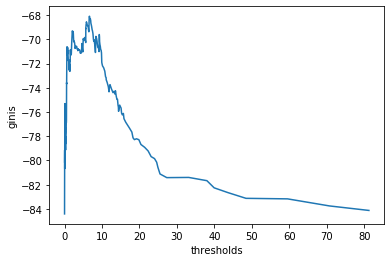

In [77]:
import matplotlib.pyplot as plt

plt.plot(thresholds, variances)
plt.xlabel('thresholds')
plt.ylabel('ginis')

### Задание 2.2 (3 балла)
Разберитесь с написанным кодом решающего дерева, заполните пропуски в коде и реализуйте недостающий метод _predict_node.

Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в лекции в разделе «Построение дерева».
- Выбор лучшего разбиения необходимо производить по критерию Джини
- Критерий останова: все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку
- Ответ в листе: наиболее часто встречающийся класс в листе

In [10]:
class DecisionTree:
    def __init__(
        self, 
        feature_types: Union[List[str], np.ndarray], 
        max_depth: int = None, 
        min_samples_split: int = None, 
        min_samples_leaf: int = None,
        task: str = "classification"
    ) -> None:
        
        if np.any(list(map(lambda x: x != "real" and x != "categorical", feature_types))):
            raise ValueError("There is unknown feature type")

        # В этой переменной будем хранить узлы решающего дерева. Каждая вершина хранит в себе идентификатор того,
        # является ли она листовой. Листовые вершины хранят значение класса для предсказания, нелистовые - правого и
        # левого детей (поддеревья для продолжения процедуры предсказания)
        self._tree = {}
        
        # типы признаков (категориальные или числовые)
        self._feature_types = feature_types
        
        # гиперпараметры дерева
        self._max_depth = max_depth
        self._min_samples_split = min_samples_split
        self._min_samples_leaf = min_samples_leaf
        self.task = task

    def _fit_node(
        self, 
        sub_X: np.ndarray, 
        sub_y: np.ndarray, 
        node: dict
    ) -> None:
        
        # критерий останова
        if np.all(sub_y == sub_y[0]):
            node["type"] = "terminal"
            node["class"] = sub_y[0]
            return

        feature_best, threshold_best, gini_best, split = None, None, None, None
        for feature in range(sub_X.shape[1]):
            feature_type = self._feature_types[feature]
            categories_map = {}

            # подготавливаем признак для поиска оптимального порога
            if feature_type == "real":
                feature_vector = sub_X[:, feature]
            elif feature_type == "categorical":
                # здесь могла быть реализация более сложного подхода к обработке категориального признака
                feature_vector = sub_X[:, feature]

            # ищем оптимальный порог
            _, _, threshold, gini = find_best_split(feature_vector, sub_y, self.task, feature_type)
            
            if gini_best is None or gini > gini_best:
                feature_best = feature
                gini_best = gini

                # split - маска на объекты, которые должны попасть в левое поддерево
                if feature_type == "real":
                    threshold_best = threshold
                    split = feature_vector <= threshold_best  # !тут мой код!
                elif feature_type == "categorical":
                    # в данной реализации это просто значение категории
                    threshold_best = threshold
                    split = feature_vector == threshold_best  # !тут мой код!
                else:
                    raise ValueError

        # записываем полученные сплиты в атрибуты класса
        if feature_best is None:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return

        node["type"] = "nonterminal"

        node["feature_split"] = feature_best
        if self._feature_types[feature_best] == "real":
            node["threshold"] = threshold_best
        elif self._feature_types[feature_best] == "categorical":
            node["category_split"] = threshold_best
        else:
            raise ValueError
            
        node["left_child"], node["right_child"] = {}, {}
        self._fit_node(sub_X[split], sub_y[split], node["left_child"])
        self._fit_node(sub_X[np.logical_not(split)], sub_y[np.logical_not(split)], node["right_child"])

    def _predict_node(self, x: np.ndarray, node: dict) -> int:
        """
        Предсказание начинается с корневой вершины дерева и рекурсивно идёт в левое или правое поддерево в зависимости от значения
        предиката на объекте. Листовая вершина возвращает предсказание.
        :param x: np.array, элемент выборки
        :param node: dict, вершина дерева
        """
        if (node["type"] == "terminal"):
            return node["class"] 
    
        feature_best = node["feature_split"]
        if self._feature_types[feature_best] == "categorical":
            if x[feature_best] == node["category_split"]:
                return self._predict_node(x, node["left_child"])
            else:
                return self._predict_node(x, node["right_child"])
        else:
            if x[feature_best] <= node["threshold"]:
                return self._predict_node(x, node["left_child"])
            else:
                return self._predict_node(x, node["right_child"])

    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        self._fit_node(X, y, self._tree)

    def predict(self, X: np.ndarray) -> np.ndarray:
        predicted = []
        for x in X:
            predicted.append(self._predict_node(x, self._tree))

        return np.array(predicted)

### Задание 2.3 (1 балл)
Загрузите таблицу [students.csv](https://drive.google.com/file/d/0B2zoFVYw1rN3a0d0Zm43TzQ4aUU/view?usp=sharing) (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте scatter-графики "значение признака — класс" для всех пяти признаков.

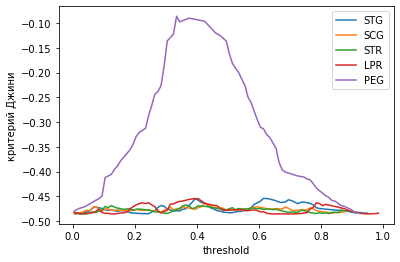

In [42]:
data = pd.read_csv('students.csv')

feats = data.iloc[:, :5]
target = data.iloc[:, -1]
names = data.columns

for i in range(5):
    thresholds, variances, threshold_best, variance_best = find_best_split(data.iloc[:, i], target)
    plt.plot(thresholds, variances, label = names[i])
    
plt.legend()
plt.xlabel("threshold")
plt.ylabel("критерий Джини")
plt.show()

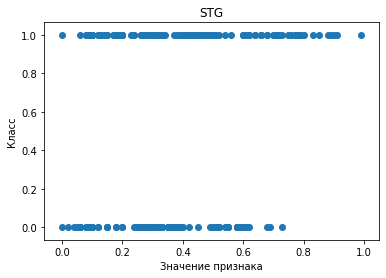

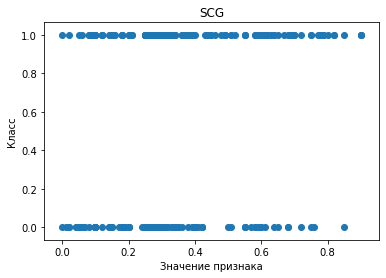

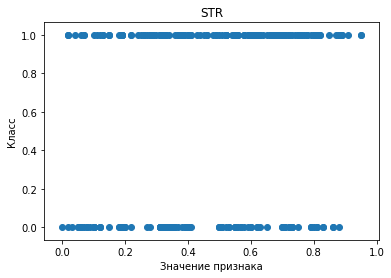

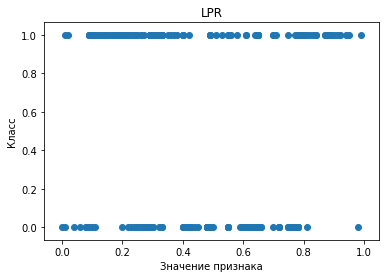

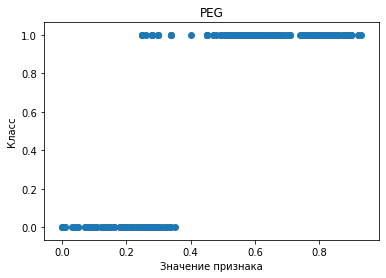

In [43]:
for i in range(5):
    plt.scatter(data.iloc[:, i], target)
    plt.title(names[i])
    plt.xlabel("Значение признака")
    plt.ylabel("Класс")
    plt.show()

### Задание 2.4 (1 балл)

**Задача**. Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой scatter-графиков? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

**Ответ**. Наибольший критерий Джини --- т.е. наиболее близкий к нулю (а значит, когда хаотичность наиболее близка к нулю: что нам и нужно) --- когда производим отбор по PEG, причем разница с отбором по остальным признакам довольно значительная.

Действительно, для scatter-графика PEG мы можем провести вертикальную линию (порог) так, чтобы классы достаточно хорошо разделились. Для остальных графиков видим, что сделать это сносно не удастся.

Вид кривой для "хороших" признаков имеет одну явную вершину-выпуклость, в ее совсем вершине как раз хорошее разбиение. Если критерий Джини в целом сначала все лучше и лучше (кривая возрастает), а потом все хуже и хуже (кривая убывает), то поделится хорошо. А если критерий то улучшается, то ухудшается, то обратно улучшается, то снова ухудшается, то выбрать порог, чтобы осмысленно поделить, вряд ли удастся, ведь мы не можем провести вертикальную линию так, чтобы отделить значения получше от значений похуже, они повторяются.

### Задание 2.5 (1 балл)

Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). Вам нужно скачать таблицу agaricus-lepiota.data (из [Data Folder](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/)), прочитать ее с помощью pandas, применить к каждому столбцу LabelEncoder (из sklearn), чтобы преобразовать строковые имена категорий в натуральные числа. Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

In [44]:
# закодируем столбцы

from sklearn import preprocessing
data = pd.read_csv('agaricus-lepiota.data').apply(preprocessing.LabelEncoder().fit_transform)

In [45]:
# отделяю признаки от таргета

feat = data.iloc[:, 1:]
target = data.iloc[:, 0]

In [46]:
# разбиваю на обучение и тест

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(feat, target, test_size=0.5, random_state=42)

In [47]:
# обучаю

Tree = DecisionTree(["categorical"] * feat.shape[1])
Tree.fit(np.array(X_train), np.array(y_train))  # т.к. функция принимает ndarray, а не dataframe

In [48]:
# предсказываю и оцениваю
from sklearn.metrics import accuracy_score

y_pred = Tree.predict(np.array(X_test))
print(accuracy_score(y_test, y_pred))

1.0


## Часть 3: бэггинг, случайный лес

В данной части будем работать [с задачей предсказания диабета у пациента](https://www.kaggle.com/uciml/pima-indians-diabetes-database/data). Посмотрим на работу бэггинга над решающими деревьями и случайного леса, сравним их работу.

In [63]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [64]:
data = pd.read_csv('diabetes.csv')
print(f"Dataset shape: {data.shape}")
data.head()

Dataset shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Посмотрим на распределение целевой переменной

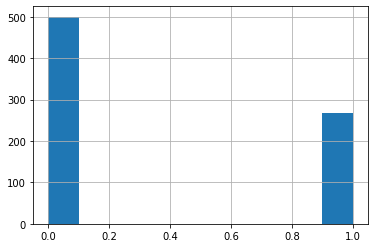

In [53]:
data['Outcome'].hist()
plt.show()

Разделите данные на признаки и целевую переменную. Разбейте датасет на тренировочную и тестовую части в отношении 70:30.

In [65]:
from sklearn.model_selection import train_test_split
target = data['Outcome']
feat = data.iloc[:, 0:8]
X_train, X_test, y_train, y_test = train_test_split(feat, target, test_size=0.3, random_state=42)

### Задание 3.1 (1 балл)

Обучите [`BaggingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) на 50 деревьях. Оцените качество классификации на тестовой выборке по метрикам `accuracy`, `precision` и `recall`, `auc_roc`.

In [66]:
from sklearn.ensemble import BaggingClassifier

clf = BaggingClassifier(n_estimators=50)
clf.fit(X_train, y_train)

y_test_predict = clf.predict(X_test)
print("accuracy:", accuracy_score(y_test, y_test_predict), "precision:", precision_score(y_test, y_test_predict), 
      "recall:", recall_score(y_test, y_test_predict), "auc_roc:", roc_auc_score(y_test, y_test_predict))

accuracy: 0.7445887445887446 precision: 0.6235294117647059 recall: 0.6625 auc_roc: 0.7252897350993377


### Задание 3.2 (1 балл)

Теперь обучите Random Forest с таким же количеством деревьев. Оцените качество классификации по тем же метрикам. Какая из двух построенных моделей показала себя лучше?

In [62]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=50)
rf.fit(X_train, y_train)

y_test_predict = rf.predict(X_test)
print("accuracy:", accuracy_score(y_test, y_test_predict), "precision:", precision_score(y_test, y_test_predict), 
      "recall:", recall_score(y_test, y_test_predict), "auc_roc:", roc_auc_score(y_test, y_test_predict))

accuracy: 0.7272727272727273 precision: 0.6024096385542169 recall: 0.625 auc_roc: 0.703228476821192


Лучше себя показал бэггинг.

### Задание 3.3 (1 балл)

Для случайного леса проанализируйте значение AUC-ROC на этих же данных в зависимости от изменения параметров (можете сделать обычный перебор с обучением/тестированием в цикле):
* `'n_estimators'` (можно перебрать около 10 значений из отрезка от 10 до 1500)
* `'min_samples_leaf'` (сетку значений можете выбрать на ваше усмотрение)

Постройте соответствующие графики зависимости AUC-ROC от этих параметров. Используйте heat map для визуализации. Какие выводы вы можете сделать?

In [67]:
# посчитаем AUC_ROC для ста значений. Кажется, было логичнее сразу записывать в таблицу...

n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1500, num = 10)]
min_samples_leaf = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]

AUC_ROC = []
models = []
for n in n_estimators:
    for m in min_samples_leaf:
        rf = RandomForestClassifier(n_estimators=n, min_samples_leaf = m)
        rf.fit(X_train, y_train)
        y_test_predict = rf.predict(X_test)
        AUC_ROC.append(roc_auc_score(y_test, y_test_predict))
        models.append(rf)

In [68]:
# построим соответствующую таблицу

AUC_ROC = np.array(AUC_ROC).reshape((10, 10))
AUC_ROC_data = pd.DataFrame(AUC_ROC, columns=min_samples_leaf, index=n_estimators)
AUC_ROC_data.index.names=['n_estimators']
AUC_ROC_data.columns.names=['min_samples_leaf']
AUC_ROC_data

min_samples_leaf,2,7,12,18,23,28,34,39,44,50
n_estimators,,,,,,,,,,
100,0.719412,0.732657,0.727152,0.698841,0.711714,0.692964,0.699214,0.702525,0.699586,0.715770
255,0.741474,0.729346,0.704346,0.717964,0.724214,0.715025,0.687086,0.693336,0.677897,0.696647
411,0.722724,0.720157,0.710969,0.711341,0.717964,0.715025,0.690025,0.690025,0.696647,0.684147
566,0.725662,0.720157,0.710969,0.717964,0.711714,0.711714,0.699214,0.699214,0.690397,0.677897
722,0.735596,0.729346,0.717591,0.717964,0.705464,0.711714,0.699214,0.687086,0.687086,0.693709
877,0.726035,0.719785,0.714280,0.714652,0.721275,0.702525,0.693336,0.690025,0.687459,0.681209
1033,0.728974,0.726407,0.714280,0.714652,0.711714,0.711714,0.699214,0.702897,0.706209,0.684147
1188,0.741846,0.729719,0.710969,0.711341,0.717964,0.711714,0.712086,0.699586,0.693709,0.697020
1344,0.735596,0.732657,0.710969,0.714652,0.717964,0.715025,0.690025,0.693336,0.687459,0.684147


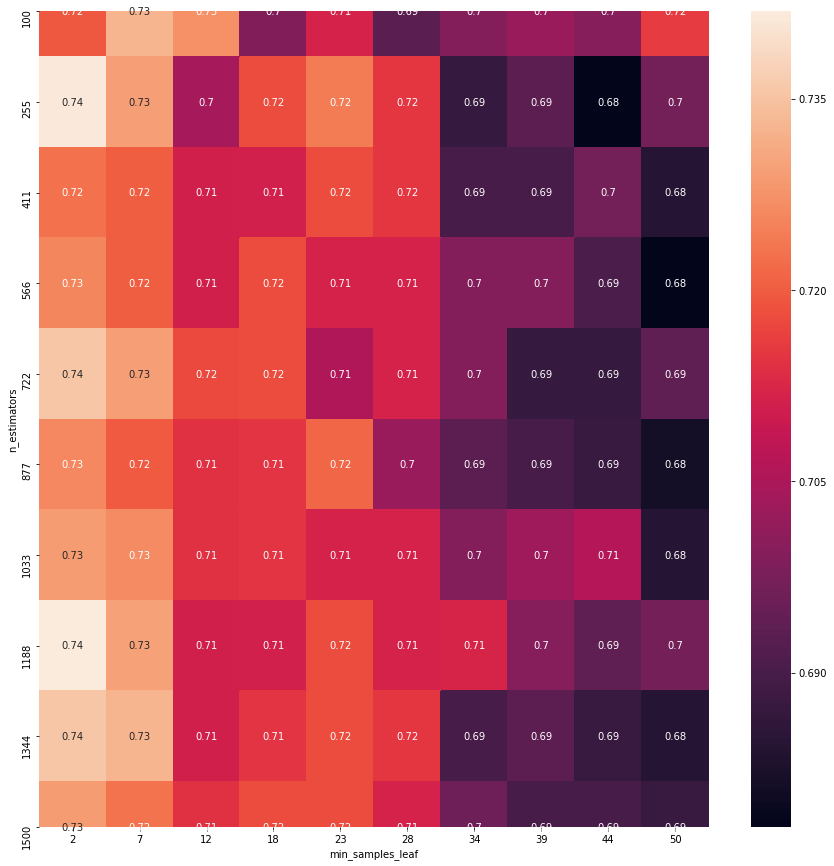

In [69]:
# построим визуализацию 

import seaborn as sns

plt.figure(figsize=(15, 15))
sns.heatmap(AUC_ROC_data, annot=True)

В целом в последних четырех столбцах значения так себе, особенно в последних двух. Получается, что при маленьких значениях min_samples_leaf результаты лучше, чем при больших, и лучшие достигаются при значениях, вероятно, до десяти. Для n_estimators таких явных выводов сделать не можем: где-то при увеличении становится чуть лучше, где-то чуть хуже, но при 1188 и 722, кажется, получше, чем везде; но главное --- что при маленьких min_samples_leaf в целом все хорошо, а при больших --- в целом все плохо.

### Задание 3.4 (1 балл)

Для лучшей модели случайного леса посчитайте важность признаков и постройте bar plot. Какой признак оказался самым важным для определения диабета?

In [70]:
# узнаем лучшую модель

best = np.argmax(AUC_ROC)
model = models[best]

In [71]:
# посчитаем важность признаков 

model.feature_importances_

array([0.0721419 , 0.28593921, 0.07946265, 0.06340356, 0.06988782,
       0.17281811, 0.10443438, 0.15191236])

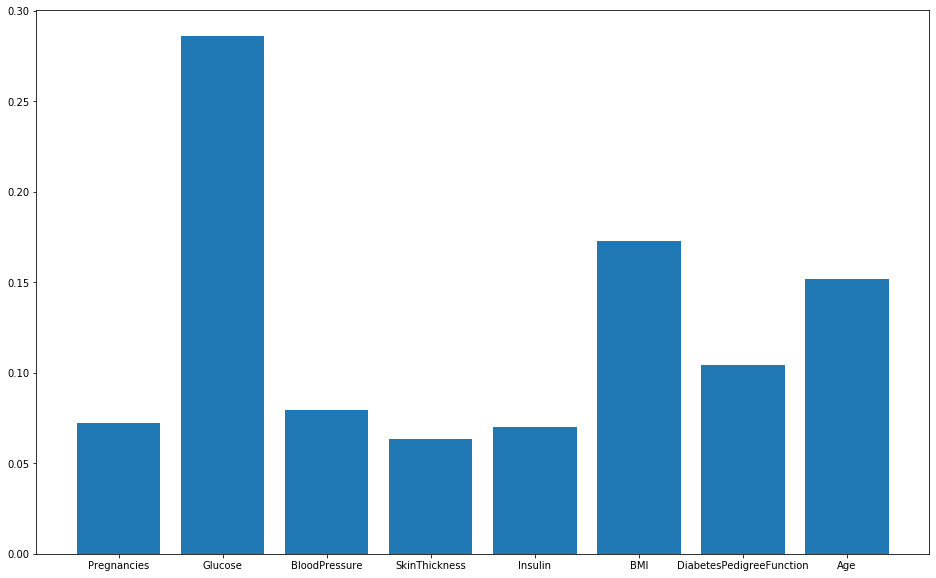

In [72]:
# построим bar plot

import matplotlib.pyplot as plt
importances = model.feature_importances_
features = np.array(feat.columns)
plt.figure(figsize=(16, 10))
plt.bar(features, importances)
plt.show()

Глюкоза самая важная.